This notebook contains a generator class for Keras called `BSONIterator` that can read directly from the BSON data. You can use it in combination with `ImageDataGenerator` for doing data augmentation.

In [1]:
import os, sys, math, io
import numpy as np
import pandas as pd
import multiprocessing as mp
import bson
import struct
from PIL import Image
import time
import shutil

%matplotlib inline
import matplotlib.pyplot as plt

from collections import defaultdict
from tqdm import *


In [2]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import Dataset

In [3]:
train_offsets_df = pd.read_csv("train_offsets.csv", index_col=0)
train_images_df = pd.read_csv("train_images_all.csv", index_col=0)
val_images_df = pd.read_csv("val_images_all.csv", index_col=0)
categories_df = pd.read_csv('categories_name_to_id.csv')

/home/bowen/anaconda3/envs/cdiscount/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
idx2l1 = list(categories_df['category_level1'])
idx2l2 = list(categories_df['category_level2'])

In [5]:
data_dir = "./input/"
# file_dir = r'C:\Users\YANG\Downloads\cdiscount'
train_bson_path = os.path.join(data_dir, "train.bson")
train_bson_file = open(train_bson_path, "rb")

# Part 2: The generator

First load the lookup tables from the CSV files (you don't need to do this if you just did all the steps from part 1).

The Keras generator is implemented by the `BSONIterator` class. It creates batches of images (and their one-hot encoded labels) directly from the BSON file. It can be used with multiple workers.

**Note:** For fastest results, put the train.bson and test.bson files on a fast drive (SSD).

See also the code in: https://github.com/fchollet/keras/blob/master/keras/preprocessing/image.py

In [6]:
class BSONIterator(Dataset):
    def __init__(self, bson_file, images_df, offsets_df, transform, mode = 'train'):
        super(BSONIterator, self).__init__()
        self.file = bson_file
        self.images_df = images_df
        self.offsets_df = offsets_df
        self.transform = transform
        self.mode = mode

    def __getitem__(self, idx):
        image_row = self.images_df.iloc[idx]
        product_id = image_row["product_id"]
        offset_row = self.offsets_df.loc[product_id]
        # Random access this product's data from the BSON file.
        self.file.seek(offset_row["offset"])
        item_data = self.file.read(offset_row["length"])
        # Grab the image from the product.
        item = bson.BSON.decode(item_data)
        img_idx = image_row["img_idx"]
        bson_img = item["imgs"][img_idx]["picture"]

        # Load the image.
        image = io.BytesIO(bson_img)
        img = Image.open(image)
        x = self.transform(img)
        if self.mode == 'train':
            idx = int(image_row["category_idx"])
            level1 = int(idx2l1[idx])
            level2 = int(idx2l2[idx])
            
            target1 = torch.LongTensor([level1])
            target2 = torch.LongTensor([level2])
            target3 = torch.LongTensor([idx])
            return x, target1, target2, target3 #for the sake of pin_memory and async
        if self.mode == 'valid':
            y = image_row["category_idx"]
            return x, y
        else:
            return x
    
    def __len__(self):
        return len(self.images_df)

In [7]:
# mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
# transform_train = T.Compose([T.CenterCrop(size=160), T.RandomHorizontalFlip(), T.ToTensor(),
#                              T.Normalize(mean=mean, std=std)])
# transform_val = T.Compose([T.CenterCrop(size=160), T.ToTensor(),T.Normalize(mean=mean, std=std)])

In [8]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
transform_train = T.Compose([T.RandomHorizontalFlip(), 
                             T.ToTensor(),T.Normalize(mean=mean, std=std)])
transform_val = T.Compose([T.ToTensor(),T.Normalize(mean=mean, std=std)])

Create a generator for training and a generator for validation.

In [9]:
train_gen = BSONIterator(train_bson_file, train_images_df, train_offsets_df, transform_train, mode = 'train')
val_gen = BSONIterator(train_bson_file, val_images_df, train_offsets_df, transform_val, mode = 'valid')

In [10]:
print(len(train_gen), len(val_gen))

12129141 242152


In [11]:
batch_size = 256
loader_train = DataLoader(train_gen, batch_size=batch_size, 
                          sampler=sampler.RandomSampler(train_gen), num_workers=1, pin_memory = True)
loader_val = DataLoader(val_gen, batch_size=batch_size, 
                          sampler=sampler.SequentialSampler(val_gen), num_workers=1, pin_memory = True)

In [12]:
print(len(loader_train), len(loader_val))

47380 946


# Part 3: Training

Create a very Resnet18 model and train it, to test that the generators work.

**ResNet18**

In [13]:
# model = torchvision.models.resnet18(pretrained=True)
# model.avgpool = nn.AvgPool2d(kernel_size = 6)
# model.fc = nn.Linear(in_features=512, out_features=5270) #or 49 + 483 + 5270
# for layer in [model.conv1, model.bn1, model.relu, model.maxpool, model.layer1, model.layer2]:
#     for param in layer.parameters():
#         param.requires_grad = False

**ResNet50**

In [14]:
model = torchvision.models.resnet50(pretrained=False)
model.avgpool = nn.AvgPool2d(kernel_size = 6)
model.fc = nn.Linear(in_features=2048, out_features=5270) #or 49 + 483 + 5270

In [15]:
trained_model = 'model_best.pth.tar'

def load_model(model, trained_model):
    if os.path.isfile(trained_model):
        print("=> loading checkpoint '{}'".format(trained_model))
        checkpoint = torch.load(trained_model)
        model.load_state_dict(checkpoint['state_dict'])
        print("=> loaded checkpoint '{}'".format(trained_model))
        return model
    else:
        print("=> no checkpoint found at '{}'".format(best_model))

In [16]:
model = load_model(model, trained_model)

=> loading checkpoint 'model_best.pth.tar'
=> loaded checkpoint 'model_best.pth.tar'


In [17]:
model.fc.weight.data.size(), model.fc.bias.data.size()


(torch.Size([5270, 2048]), torch.Size([5270]))

In [18]:
new_fc = nn.Linear(in_features=2048, out_features=49 + 483 + 5270)
for param in new_fc.parameters():
    param.requires_grad = True
init.kaiming_normal(new_fc.weight.data)
new_fc.bias.data.zero_()
new_fc.weight.size(), new_fc.bias.size()

(torch.Size([5802, 2048]), torch.Size([5802]))

In [19]:
new_fc.weight.size(), new_fc.bias.size()

(torch.Size([5802, 2048]), torch.Size([5802]))

In [20]:
new_fc.weight.data[532:] = model.fc.weight.data
new_fc.bias.data[532:] = model.fc.bias.data
model.fc = new_fc

In [21]:
for layer in [model.conv1, model.bn1, model.relu, model.maxpool, model.layer1, model.layer2, model.layer3]:
    for param in layer.parameters():
        param.requires_grad = False
model.cuda()

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): Bottleneck (
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (downsample): Sequential (
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (1): Bott

In [22]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(lr, optimizer, epoch, denominator = 2):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = lr * (0.1 ** (epoch // denominator))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    batch_size = target.size(0)
    _, pred = output.max(dim=1)
    correct = pred.eq(target)
    res = []
    for k in topk:
        correct_k = correct.float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [23]:
def train(train_loader, model, criterion, optimizer, weights, epoch, print_freq = 500):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    loss_log = []
    acc_log = []
#     top5 = AverageMeter() #only need top1

    # switch to train mode
    model.train()

    end = time.time()
    for i, (img, target1, target2, target3) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        
        img = img.cuda(async=True)
        img_var = Variable(img)
        
        target1 = target1.view(-1).cuda(async=True)
        target1_var = Variable(target1)
        target2 = target2.view(-1).cuda(async=True)
        target2_var = Variable(target2)
        target3 = target3.view(-1).cuda(async=True)
        target3_var = Variable(target3)

        # compute output
        output = model(img_var)
        loss1 = criterion(output[:, :49], target1_var)
        loss2=  criterion(output[:, 49:532], target2_var)
        loss3=  criterion(output[:, 532:], target3_var)
        loss = loss1*weights[0] + loss2*weights[1] + loss3*weights[2]
        # measure accuracy and record loss
        prec1 = accuracy(output[:, 532:].data, target3, topk=(1, ))[0]#only need top1
        losses.update(loss.data[0], img.size(0)) #[0] to take out the float inside torch.Tensor
        top1.update(prec1[0], img.size(0))
        loss_log.append(losses.val)
        acc_log.append(top1.val)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses, top1=top1))
    return loss_log, acc_log

In [26]:
def validate(val_loader, model, print_freq=50):
    batch_time = AverageMeter()
#     losses = AverageMeter()
    top1 = AverageMeter()
#     top5 = AverageMeter() #only need top1

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (img, target) in enumerate(val_loader):
        
        target = target.cuda(async=True)
        img = img.cuda(async=True)
        img_var = Variable(img, volatile=True)
        target_var = Variable(target, volatile=True)

        # compute output
        output = model(img_var)[:, 532:]
#         loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]#only need top1
#         losses.update(loss.data[0], img.size(0))
        top1.update(prec1[0], img.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                   i, len(val_loader), batch_time=batch_time, top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'.format(top1=top1))

    return top1.avg

Epoch: [0][0/47380]	Time 2.006 (2.006)	Data 1.154 (1.154)	Loss 4.3185 (4.3185)	Prec@1 64.844 (64.844)
Epoch: [0][500/47380]	Time 0.466 (0.474)	Data 0.000 (0.003)	Loss 0.8342 (0.9959)	Prec@1 60.547 (62.369)
Epoch: [0][1000/47380]	Time 0.469 (0.472)	Data 0.000 (0.001)	Loss 0.7571 (0.9102)	Prec@1 66.797 (61.616)
Epoch: [0][1500/47380]	Time 0.471 (0.472)	Data 0.000 (0.001)	Loss 0.7566 (0.8728)	Prec@1 62.891 (61.054)
Epoch: [0][2000/47380]	Time 0.467 (0.471)	Data 0.000 (0.001)	Loss 0.7987 (0.8479)	Prec@1 55.469 (60.704)
Epoch: [0][2500/47380]	Time 0.477 (0.473)	Data 0.000 (0.001)	Loss 0.8581 (0.8318)	Prec@1 62.109 (60.311)
Epoch: [0][3000/47380]	Time 0.474 (0.473)	Data 0.000 (0.001)	Loss 0.7006 (0.8192)	Prec@1 56.250 (60.004)
Epoch: [0][3500/47380]	Time 0.473 (0.472)	Data 0.000 (0.001)	Loss 0.5836 (0.8089)	Prec@1 65.625 (59.781)
Epoch: [0][4000/47380]	Time 0.464 (0.472)	Data 0.000 (0.001)	Loss 0.7530 (0.8012)	Prec@1 60.156 (59.552)
Epoch: [0][4500/47380]	Time 0.464 (0.472)	Data 0.000 (0.001

Epoch: [0][39000/47380]	Time 0.474 (0.471)	Data 0.000 (0.000)	Loss 0.6136 (0.6730)	Prec@1 52.734 (54.678)
Epoch: [0][39500/47380]	Time 0.473 (0.471)	Data 0.000 (0.000)	Loss 0.4348 (0.6723)	Prec@1 59.766 (54.637)
Epoch: [0][40000/47380]	Time 0.472 (0.471)	Data 0.000 (0.000)	Loss 0.5445 (0.6715)	Prec@1 54.297 (54.593)
Epoch: [0][40500/47380]	Time 0.472 (0.471)	Data 0.000 (0.000)	Loss 0.6018 (0.6707)	Prec@1 43.359 (54.553)
Epoch: [0][41000/47380]	Time 0.473 (0.471)	Data 0.000 (0.000)	Loss 0.7681 (0.6700)	Prec@1 46.484 (54.512)
Epoch: [0][41500/47380]	Time 0.475 (0.471)	Data 0.000 (0.000)	Loss 0.4846 (0.6694)	Prec@1 52.344 (54.470)
Epoch: [0][42000/47380]	Time 0.471 (0.471)	Data 0.000 (0.000)	Loss 0.6490 (0.6687)	Prec@1 48.047 (54.431)
Epoch: [0][42500/47380]	Time 0.464 (0.471)	Data 0.000 (0.000)	Loss 0.6162 (0.6681)	Prec@1 47.266 (54.394)
Epoch: [0][43000/47380]	Time 0.475 (0.471)	Data 0.000 (0.000)	Loss 0.6248 (0.6674)	Prec@1 46.484 (54.358)
Epoch: [0][43500/47380]	Time 0.465 (0.471)	Dat

Epoch: [0][25500/47380]	Time 0.474 (0.471)	Data 0.000 (0.000)	Loss 1.7569 (1.7940)	Prec@1 63.672 (61.598)
Epoch: [0][26000/47380]	Time 0.465 (0.471)	Data 0.000 (0.000)	Loss 1.5570 (1.7931)	Prec@1 64.062 (61.615)
Epoch: [0][26500/47380]	Time 0.473 (0.471)	Data 0.000 (0.000)	Loss 1.7385 (1.7923)	Prec@1 59.375 (61.634)
Epoch: [0][27000/47380]	Time 0.473 (0.471)	Data 0.000 (0.000)	Loss 1.7346 (1.7915)	Prec@1 60.938 (61.649)
Epoch: [0][27500/47380]	Time 0.471 (0.471)	Data 0.000 (0.000)	Loss 1.8056 (1.7906)	Prec@1 60.547 (61.669)
Epoch: [0][28000/47380]	Time 0.464 (0.471)	Data 0.000 (0.000)	Loss 1.8292 (1.7895)	Prec@1 62.500 (61.685)
Epoch: [0][28500/47380]	Time 0.463 (0.471)	Data 0.000 (0.000)	Loss 1.9678 (1.7886)	Prec@1 61.328 (61.702)
Epoch: [0][29000/47380]	Time 0.472 (0.471)	Data 0.000 (0.000)	Loss 1.6625 (1.7877)	Prec@1 64.453 (61.717)
Epoch: [0][29500/47380]	Time 0.473 (0.471)	Data 0.000 (0.000)	Loss 1.8753 (1.7868)	Prec@1 57.812 (61.735)
Epoch: [0][30000/47380]	Time 0.476 (0.471)	Dat

Epoch: [1][12000/47380]	Time 0.465 (0.470)	Data 0.000 (0.000)	Loss 0.5805 (0.5805)	Prec@1 61.328 (60.807)
Epoch: [1][12500/47380]	Time 0.477 (0.470)	Data 0.001 (0.000)	Loss 0.6636 (0.5797)	Prec@1 57.812 (60.761)
Epoch: [1][13000/47380]	Time 0.470 (0.470)	Data 0.000 (0.000)	Loss 0.7115 (0.5788)	Prec@1 53.125 (60.716)
Epoch: [1][13500/47380]	Time 0.464 (0.470)	Data 0.000 (0.000)	Loss 0.5497 (0.5780)	Prec@1 57.422 (60.668)
Epoch: [1][14000/47380]	Time 0.463 (0.470)	Data 0.000 (0.000)	Loss 0.5449 (0.5772)	Prec@1 58.203 (60.612)
Epoch: [1][14500/47380]	Time 0.463 (0.470)	Data 0.000 (0.000)	Loss 0.5654 (0.5764)	Prec@1 56.641 (60.555)
Epoch: [1][15000/47380]	Time 0.476 (0.470)	Data 0.000 (0.000)	Loss 0.6245 (0.5755)	Prec@1 56.250 (60.505)
Epoch: [1][15500/47380]	Time 0.464 (0.470)	Data 0.000 (0.000)	Loss 0.5298 (0.5748)	Prec@1 62.891 (60.464)
Epoch: [1][16000/47380]	Time 0.471 (0.470)	Data 0.000 (0.000)	Loss 0.5582 (0.5740)	Prec@1 56.250 (60.427)
Epoch: [1][16500/47380]	Time 0.466 (0.470)	Dat

Test: [600/946]	Time 0.335 (0.311)	Prec@1 0.000 (0.002)
Test: [650/946]	Time 0.309 (0.311)	Prec@1 0.000 (0.002)
Test: [700/946]	Time 0.338 (0.311)	Prec@1 0.000 (0.002)
Test: [750/946]	Time 0.281 (0.311)	Prec@1 0.000 (0.002)
Test: [800/946]	Time 0.283 (0.310)	Prec@1 0.000 (0.001)
Test: [850/946]	Time 0.281 (0.310)	Prec@1 0.000 (0.001)
Test: [900/946]	Time 0.282 (0.310)	Prec@1 0.000 (0.001)
 * Prec@1 0.002
Epoch: [1][0/47380]	Time 1.479 (1.479)	Data 1.110 (1.110)	Loss 2.8782 (2.8782)	Prec@1 57.031 (57.031)
Epoch: [1][500/47380]	Time 0.465 (0.472)	Data 0.000 (0.003)	Loss 1.4973 (1.7656)	Prec@1 67.969 (61.584)
Epoch: [1][1000/47380]	Time 0.471 (0.471)	Data 0.000 (0.002)	Loss 1.4219 (1.7272)	Prec@1 64.453 (62.207)
Epoch: [1][1500/47380]	Time 0.469 (0.470)	Data 0.000 (0.001)	Loss 1.9534 (1.7104)	Prec@1 57.422 (62.475)
Epoch: [1][2000/47380]	Time 0.471 (0.471)	Data 0.000 (0.001)	Loss 1.5477 (1.7014)	Prec@1 62.500 (62.616)
Epoch: [1][2500/47380]	Time 0.473 (0.471)	Data 0.000 (0.001)	Loss 1.593

Epoch: [1][37000/47380]	Time 0.470 (0.471)	Data 0.000 (0.000)	Loss 1.3429 (1.6121)	Prec@1 70.312 (64.475)
Epoch: [1][37500/47380]	Time 0.466 (0.471)	Data 0.000 (0.000)	Loss 1.6038 (1.6117)	Prec@1 62.891 (64.485)
Epoch: [1][38000/47380]	Time 0.473 (0.471)	Data 0.000 (0.000)	Loss 1.7701 (1.6112)	Prec@1 62.109 (64.494)
Epoch: [1][38500/47380]	Time 0.464 (0.471)	Data 0.000 (0.000)	Loss 1.7581 (1.6109)	Prec@1 60.547 (64.501)
Epoch: [1][39000/47380]	Time 0.466 (0.471)	Data 0.000 (0.000)	Loss 1.3995 (1.6106)	Prec@1 66.797 (64.506)
Epoch: [1][39500/47380]	Time 0.475 (0.471)	Data 0.000 (0.000)	Loss 1.6580 (1.6103)	Prec@1 63.281 (64.513)
Epoch: [1][40000/47380]	Time 0.471 (0.471)	Data 0.001 (0.000)	Loss 1.4348 (1.6099)	Prec@1 66.406 (64.519)
Epoch: [1][40500/47380]	Time 0.474 (0.471)	Data 0.000 (0.000)	Loss 1.6215 (1.6096)	Prec@1 62.500 (64.528)
Epoch: [1][41000/47380]	Time 0.472 (0.471)	Data 0.000 (0.000)	Loss 1.8575 (1.6092)	Prec@1 57.812 (64.536)
Epoch: [1][41500/47380]	Time 0.463 (0.471)	Dat

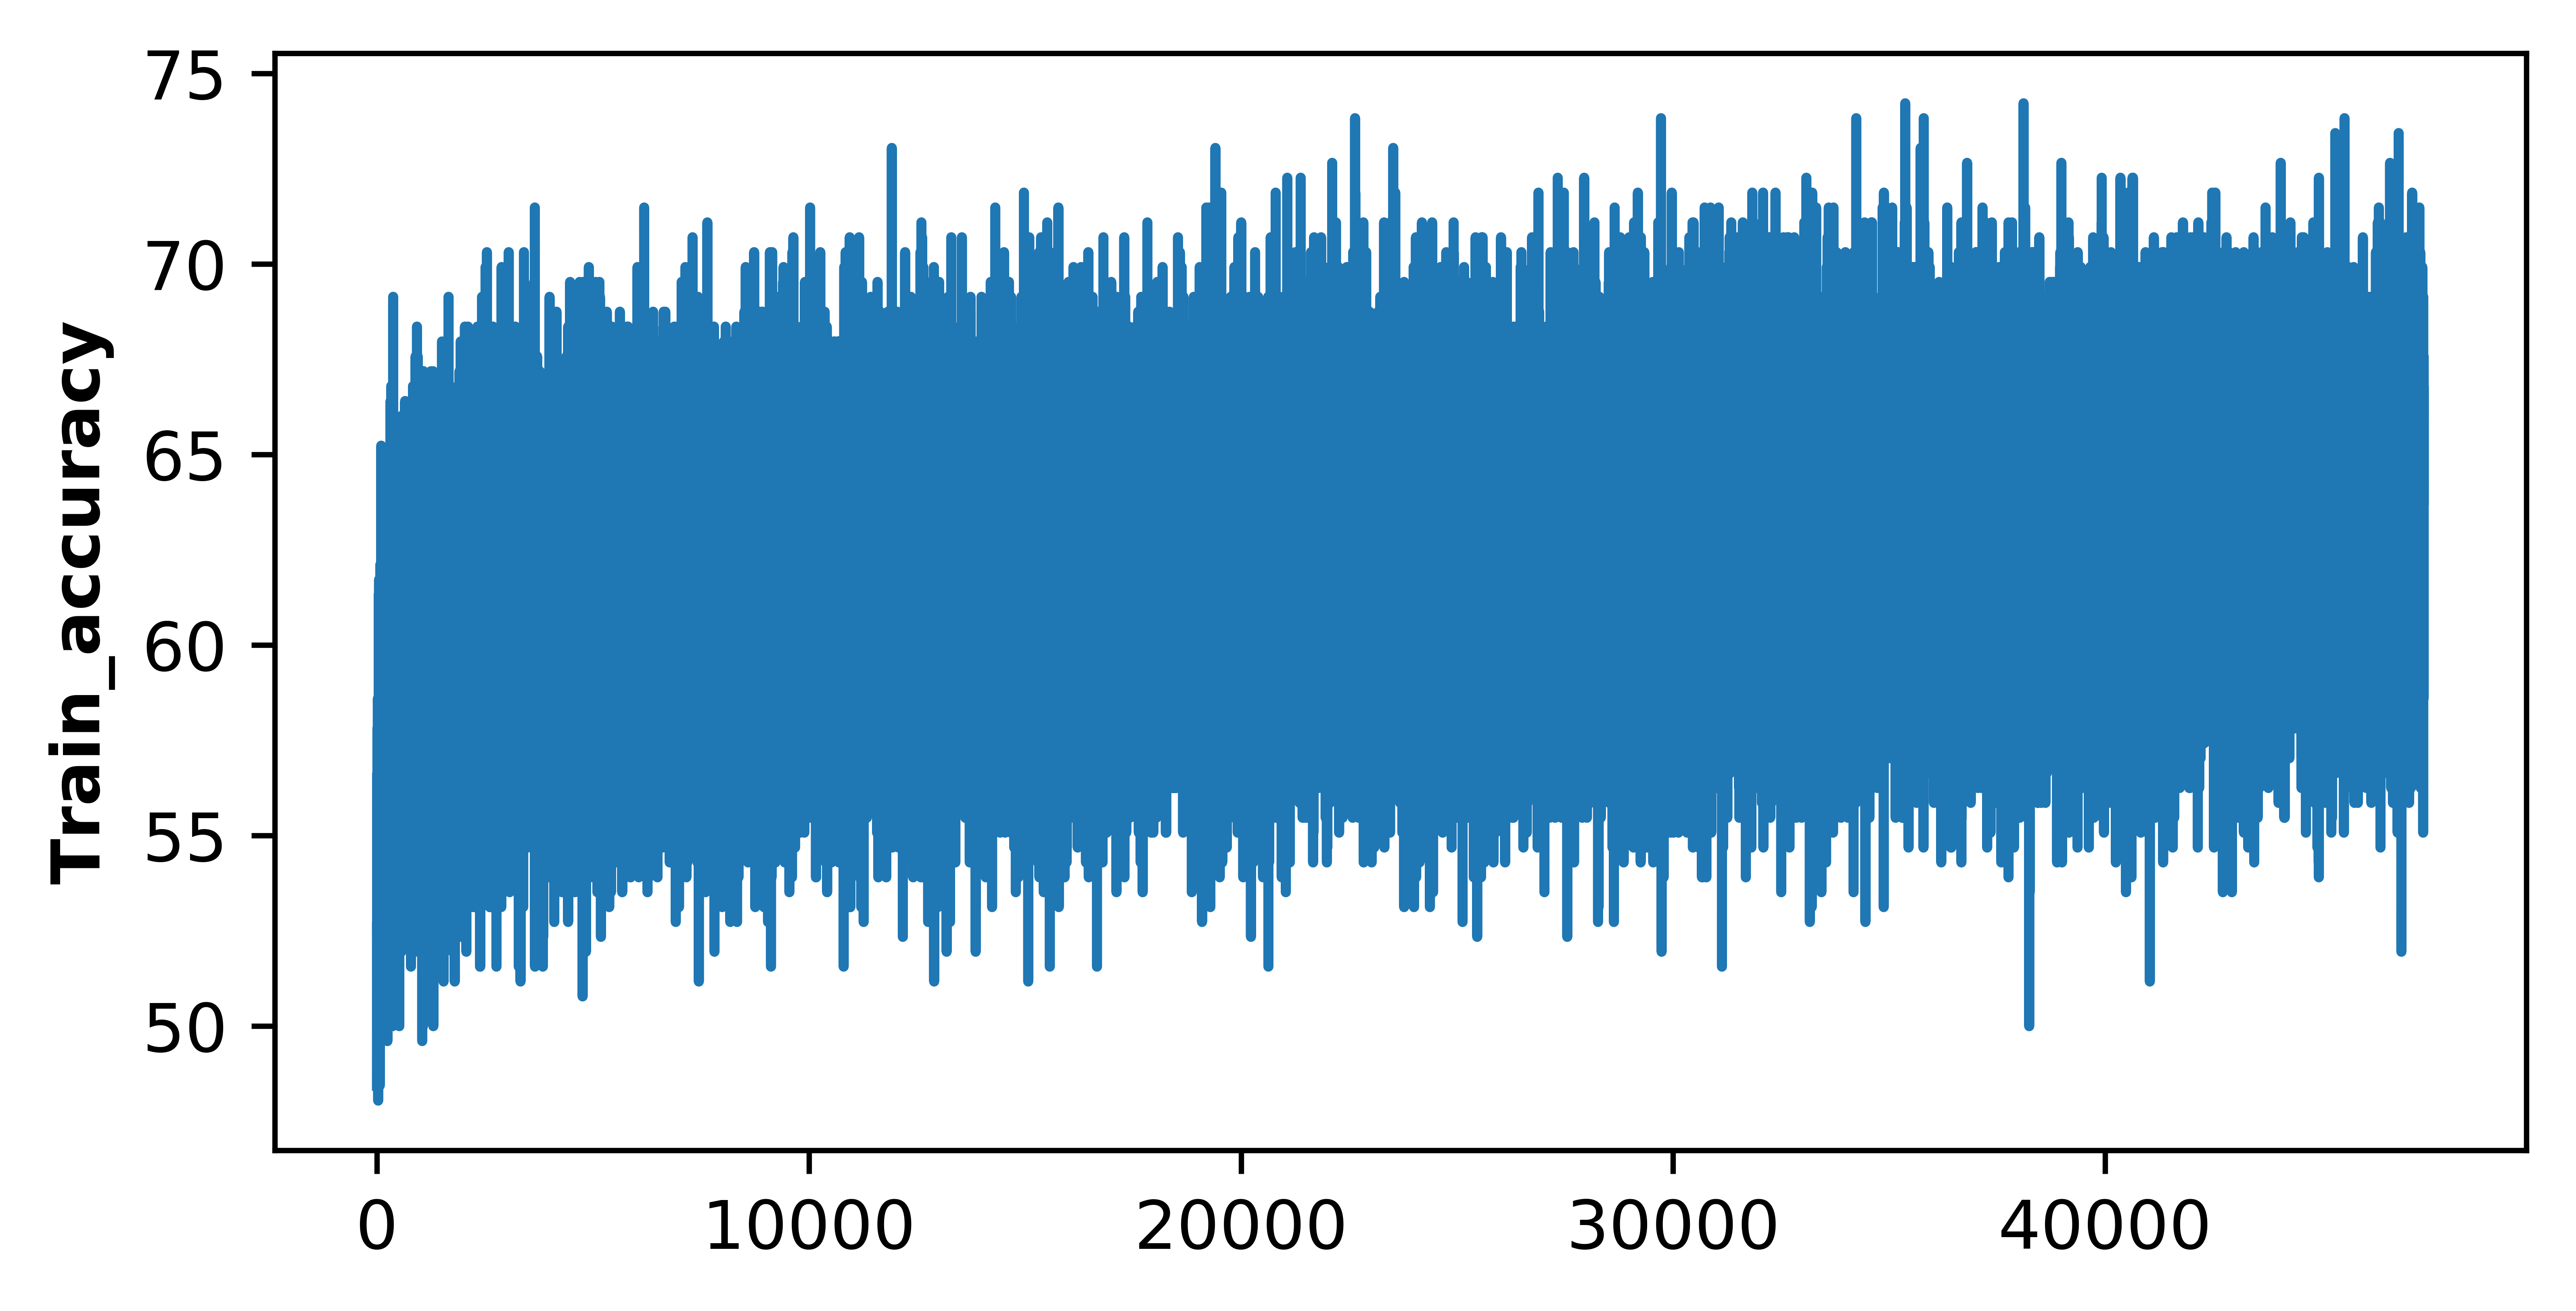

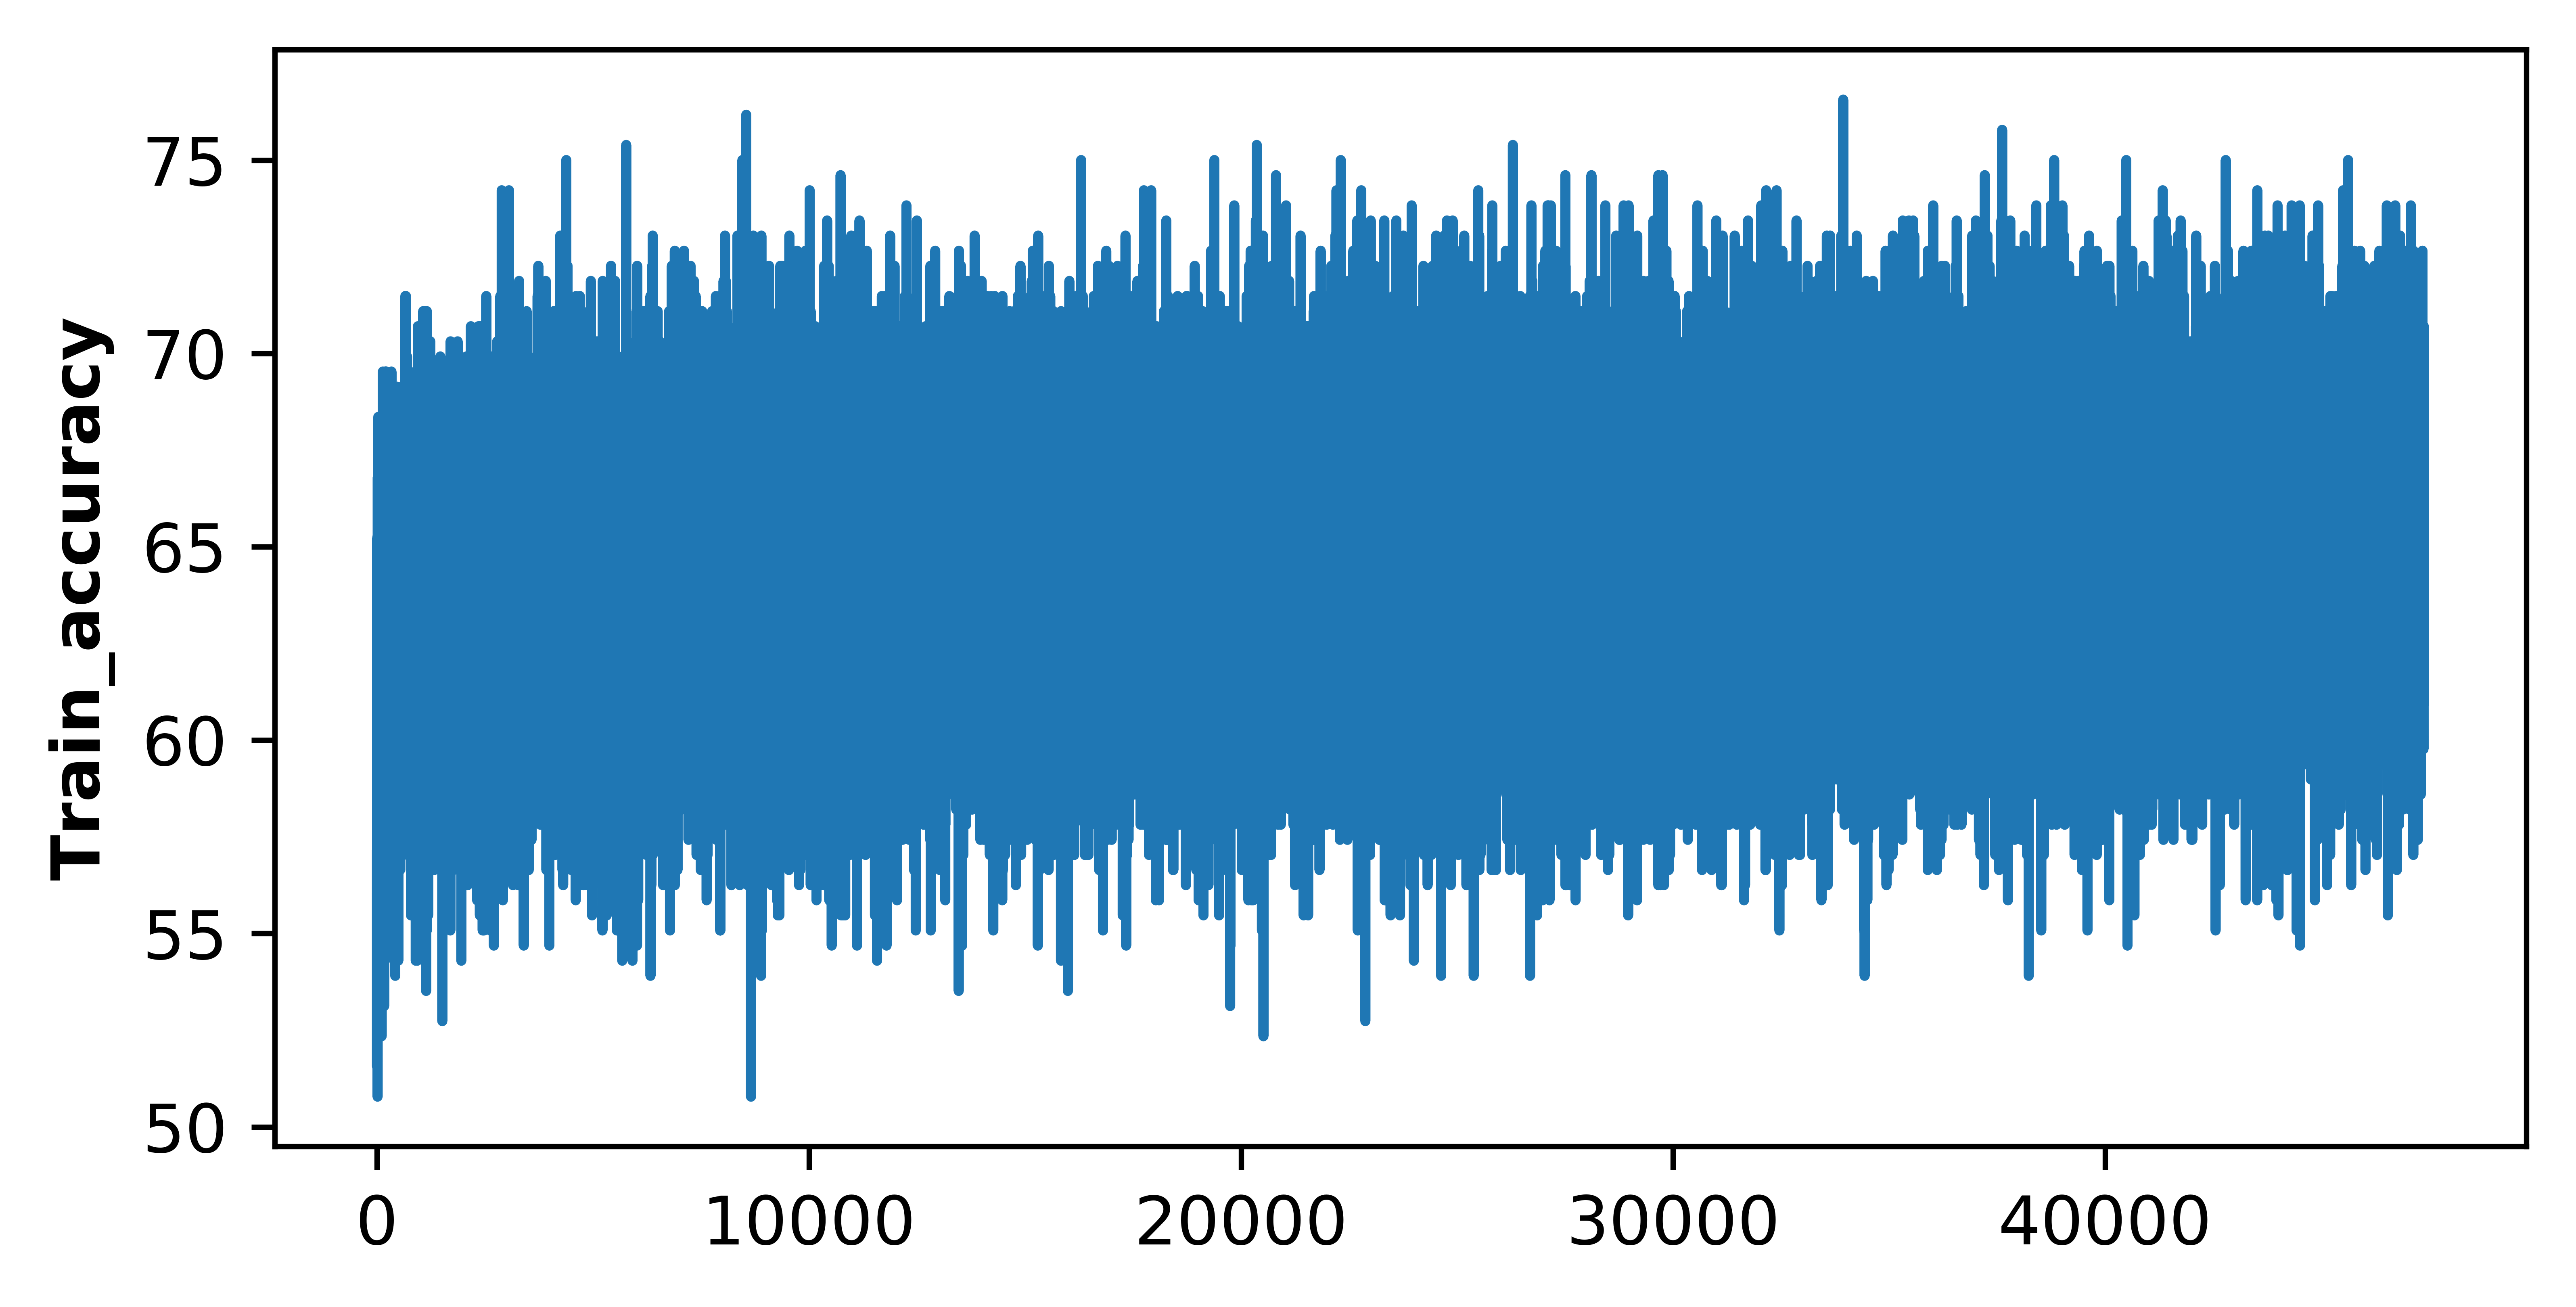

In [25]:
if __name__ == '__main__':
    best_prec1 = 64
    criterion = nn.CrossEntropyLoss().cuda()
    lr = 1e-2
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr = lr, momentum=0.9, 
                          weight_decay=0)
    resume = None
    start_epoch = 0
    epochs = 2
    arch = 'resnet50_levelID'

    for epoch in range(start_epoch, epochs):
        adjust_learning_rate(lr=lr, optimizer=optimizer, epoch=epoch, denominator=2)

        # train for one epoch
        for weights in [[1, 0, 0], [0, 0, 1]]:
            loss_log, acc_log = train(train_loader=loader_train, model=model, criterion=criterion,
                                      weights = weights, optimizer=optimizer, epoch=epoch)

        # evaluate on validation set
            prec1 = validate(val_loader=loader_val, model=model)

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        save_checkpoint({
            'epoch': epoch + 1,
            'arch': arch,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict(),
        }, is_best)

        #plot loss and acc
        fig = plt.figure(figsize = (6,3), dpi = 1200)
        loss_log = np.array(loss_log)
        ax1 = plt.subplot(121)
        ax1.plot(loss_log)
        ax1.set_ylabel('Loss', weight = 'bold')
        acc_log = np.array(acc_log)
        ax2 = plt.subplot(111)
        ax2.plot(acc_log)
        ax2.set_ylabel('Train_accuracy', weight = 'bold')
        np.savetxt(X=np.vstack((loss_log, acc_log)), fname='loss_acc_log.txt', fmt='%.3f')

In [27]:
prec1 = validate(val_loader=loader_val, model=model)

Test: [0/946]	Time 1.281 (1.281)	Prec@1 82.031 (82.031)
Test: [50/946]	Time 0.300 (0.329)	Prec@1 86.719 (66.873)
Test: [100/946]	Time 0.310 (0.316)	Prec@1 87.109 (76.334)
Test: [150/946]	Time 0.302 (0.312)	Prec@1 66.406 (80.326)
Test: [200/946]	Time 0.337 (0.309)	Prec@1 75.391 (79.194)
Test: [250/946]	Time 0.301 (0.307)	Prec@1 51.953 (79.171)
Test: [300/946]	Time 0.325 (0.306)	Prec@1 96.484 (79.597)
Test: [350/946]	Time 0.337 (0.305)	Prec@1 95.703 (80.412)
Test: [400/946]	Time 0.321 (0.305)	Prec@1 78.906 (79.891)
Test: [450/946]	Time 0.322 (0.304)	Prec@1 89.844 (78.879)
Test: [500/946]	Time 0.272 (0.303)	Prec@1 79.297 (77.515)
Test: [550/946]	Time 0.301 (0.303)	Prec@1 27.344 (76.073)
Test: [600/946]	Time 0.327 (0.303)	Prec@1 43.359 (74.713)
Test: [650/946]	Time 0.302 (0.303)	Prec@1 59.766 (73.434)
Test: [700/946]	Time 0.330 (0.303)	Prec@1 34.766 (72.365)
Test: [750/946]	Time 0.327 (0.303)	Prec@1 62.891 (70.966)
Test: [800/946]	Time 0.326 (0.303)	Prec@1 66.797 (69.558)
Test: [850/946]	T